In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
from losses import heteroscedastic_loss

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
np.set_printoptions(suppress=True)

In [3]:
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

# Data generator

In [5]:
# Attention to feedback updating function
def smooth(x,omega,lambda_par):
    return lambda_par*x + (1-lambda_par)*omega

# Logistic function for state transition
def probTrans(Attention_To_Feed,theta):
    return 1/(1 + np.exp(theta*(1/2 - Attention_To_Feed)))

# Likelihood over the rules
def Likelihood(matching_vector,y,state):
    l = np.array([matching_vector==y, 1 - (matching_vector==y)+0.00001])
    ll = l[state]/sum(l[state])
    return np.array([1/3,1/3,1/3])*0.0001 + ll*0.9999

# Posterior over the rules
def Posterior(prior, likelihood):
    n = prior * likelihood
    d = sum(n)
    return n/d
    
# Corrupted Posterior over the rules
def systemPosterior(pi_par,posterior):
    g = np.array([1/3,1/3,1/3])
    f = posterior
    h_ = pi_par*g + (1-pi_par)*f
    h = h_ / sum(h_)
    return h

# Generate the sequence of target cards codified as features matching vectors in M (0: no ambiguity, 1: ambiguity)
def MatchingMatrix(n_trials, ambiguity):
    M = np.array([np.random.choice([1,2,3,4],3,replace=ambiguity) for _ in range(n_trials)])
    return M

def GenerativeModel(Parameters, M):

    # Parameters Setting #
    lambda_par = Parameters[0]
    alpha_par = Parameters[1]
    beta_par = Parameters[2]
    pi_par = Parameters[3]
    
    # Initialize Vectors #
    max_trials = len(M) # Set the maximum number of possible trials (128 trials for the Heaton's version of the WCST)
    target_rule = np.zeros(max_trials, dtype=int) # Initialize the vector of correct rules
    correct_stimulus_card = np.zeros(max_trials, dtype=int) # Initialize the vector of correct stimulus cards
    S = np.zeros(max_trials, dtype=int) # Initialize the vector of the states (0: set-maintainance, 1: set-shifting)
    h = np.zeros((max_trials,3)) # Initialize the vectors of the system's likelihood probabilities
    rule_choice = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's rules choice
    Y = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's stimulus cards choice
    X = np.zeros(max_trials, dtype=int) # Initialize the vector of received feedback (1: correct, 0: error)
    omega = np.zeros(max_trials) # Initialize the vector of the attention to reward process
    delta = np.zeros(max_trials) # Initialize the vector of the attention to punishment process
    gamma_00 = np.zeros(max_trials) # Initialize the vector of self-transition probabilities for state 0 (set-maintenance)
    gamma_11 = np.zeros(max_trials) # Initialize the vector of self-transition probabilities for state 1 (set-shifting)
    target_rules_vector = np.tile(np.array([1,2,3]),10) # Vector of possible target rules
    
    # First Trial (the first correct response is given as in the standard version of Heaton's WCST) #
    i = 0 # Target rule indicator
    target_rule[0] = target_rules_vector[i] # Actual target rule
    correct_stimulus_card[0] = M[0][target_rule[0]-1] # Correct stimulus card
    S[0] = 0 # Start at state 0 (set-maintenance)
    h[0] = np.array([1/3,1/3,1/3]) # Prior over the rules
    rule_choice[0] = 1 # Sample the first correct rule
    Y[0] = M[0][rule_choice[0]-1] # Select the first correct stimulus card
    X[0] = 1 # Correct response
    omega[0] = smooth(X[0],0.5,lambda_par) # Update omega
    gamma_00[0] = probTrans(omega[0],alpha_par) # Compute transition probabilities
    gamma_01 = 1 - gamma_00[0]
    gamma_11[0] = probTrans(omega[0],beta_par) # Compute transition probabilities
    gamma_10 = 1 - gamma_11[0]
    G = np.array([[gamma_00[0],gamma_01],[gamma_10,gamma_11[0]]]) # State Transition Matrix
    
    # Task execution #
    T = len(M) # Set the maximum number of trials attainable
    c = 0 # Initialize the stopping criterion
    for t in range(1,T):
        target_rule[t] = target_rules_vector[i] # Current target rule
        correct_stimulus_card[t] = M[t][target_rule[t]-1] # Current correct stimulus card
        S[t] = np.random.choice([0,1],1,p=G[S[t-1]]) # Sampling the current state
        f = Likelihood(M[t-1],Y[t-1],S[t]) # Compute the likelihood over the rules condition on the current state
        hh = Posterior(h[t-1],f) # Compute the Posterior over the rules
        h[t] = systemPosterior(pi_par,hh) # Compute the corrupted Posterior over the rules
        rule_choice[t] = np.random.choice([1,2,3],1,p=h[t]) # Sampling the rule 
        Y[t] = M[t][rule_choice[t]-1] # Select the stimulus card according to the rule
        X[t] = int(Y[t] == correct_stimulus_card[t]) # Feedback
        omega[t] = smooth(X[t],omega[t-1],lambda_par) # Update omega for the next state transition
        gamma_00[t] = probTrans(omega[t],alpha_par) # Compute the transition probabilities for the next trial
        gamma_01 = 1 - gamma_00[t]
        gamma_11[t] = probTrans(omega[t],beta_par) # Compute the transition probabilities for the next trial
        gamma_10 = 1 - gamma_11[t]
        G = np.array([[gamma_00[t],gamma_01],[gamma_10,gamma_11[t]]]) # Transition Matrix for the next trial
        
        # Stopping condition (The task ends when the agent collects a series of 6 10 consecutive correct responses)
        if X[t] == 1:
            if X[t] == X[t-1]:
                c = c + 1
            else:
                c = 0
        if c == 9:
            i = i + 1
            c = 0
            
        if i == 6:
            break
    
    
    return np.c_[X, Y]


def generate_data(batch_size, pbounds, n_trials=128, to_tensor=True, ambiguity=True):
    """
    Generates a batch of parameters and data.
    """
    
    # Prepare data containers
    X = np.zeros((batch_size, n_trials, 2)).astype(np.float32)
    M = np.zeros((batch_size, n_trials, 3)).astype(np.float32)
    
    # Generate variable parameters
    lambdas = np.random.uniform(pbounds['lambda'][0], pbounds['lambda'][1], size=batch_size)
    alphas = np.random.uniform(pbounds['alpha'][0], pbounds['alpha'][1], size=batch_size)
    betas = np.random.uniform(pbounds['beta'][0], pbounds['beta'][1], size=batch_size)
    pis = np.random.uniform(pbounds['pi'][0], pbounds['pi'][1], size=batch_size)
    
    theta = np.c_[lambdas, alphas, betas, pis].astype(np.float32)
    
    for bi in range(batch_size):
        
        # Generate a matching matrix
        M_i = MatchingMatrix(n_trials, ambiguity=ambiguity)
        
        # Generate data
        X_i = GenerativeModel([lambdas[bi], alphas[bi], betas[bi], pis[bi]], M_i)
        
        # Store data
        X[bi] = X_i
        M[bi] = M_i
        
        if (bi+1) % 1000 == 0:
            print('Generated {} datasets.'.format(bi+1))
    
    X = np.concatenate((X, M), axis=-1)
    
    if to_tensor:
        X, theta = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(theta, dtype=tf.float32)
    return X, theta

# Train loop functions

In [6]:
def run_epoch_online(model, optimizer, data_gen, batch_size, iterations, 
              X_test, y_test, p_bar, transform=None, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for it in range(1, iterations+1):
            
        X_batch, y_batch = data_gen(batch_size)
        if transform is not None:
            X_batch, y_batch = transform(X_batch, y_batch)

        with tf.GradientTape() as tape:

            # Forward pass
            y_mean, y_var = model(X_batch)

            # Compute total loss
            loss = heteroscedastic_loss(y_batch, y_mean, y_var)

        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)

        # Validations score
        y_mean_val, y_var_val = model(X_test)
        train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
        val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
        val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)


        if clip_value is not None:
            gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        gradients = [tf.clip_by_value(grad, -5, 5) for grad in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("It:{0},Loss:{1:.3f},Val.Loss:{2:.3f},Rec.:{3:.3f},Val.Rec.:{4:.3f}".format(
        it, loss.numpy(), val_loss.numpy(), train_rec.numpy(), val_rec.numpy()))
        p_bar.update(1)
        
        
def run_epoch_offline(model, optimizer, dataset, X_test, y_test, p_bar, transform=None, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for bi, (X_batch, y_batch) in enumerate(dataset):
        
        if transform is not None:
            X_batch, y_batch = transform(X_batch, y_batch)

        with tf.GradientTape() as tape:

            # Forward pass
            y_mean, y_var = model(X_batch)

            # Compute total loss
            loss = heteroscedastic_loss(y_batch, y_mean, y_var)

        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)

        # Validations score
        y_mean_val, y_var_val = model(X_test)
        train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
        val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
        val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)


        if clip_value is not None:
            gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        gradients = [tf.clip_by_value(grad, -5, 5) for grad in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("Batch:{0},Loss:{1:.3f},Val.Loss:{2:.3f},Rec.:{3:.3f},Val.Rec.:{4:.3f}".format(
        bi+1, loss.numpy(), val_loss.numpy(), train_rec.numpy(), val_rec.numpy()))
        p_bar.update(1)

# Inference network

In [44]:
class InferenceNetwork(tf.keras.Model):
    
    def __init__(self, theta_dim, embed=True, summary_dim=128):
        super(InferenceNetwork, self).__init__()
        

        # This will embed the categorical predictors
        if embed:
            self.embeddings = [tf.keras.layers.Dense(32) for _ in range(5)]
        else:
            self.embeddings = None
        
        
        # This model will then run through the concatenated embeddings
        self.lstm = tf.keras.layers.CuDNNLSTM(summary_dim, recurrent_initializer='glorot_uniform')
        
        # This model will predict the mean and variance of the distro
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(summary_dim, activation='elu'),
            tf.keras.layers.Dense(summary_dim, activation='elu'),
            tf.keras.layers.Dense(summary_dim, activation='elu'),
            tf.keras.layers.Dense(summary_dim, activation='elu'),
            tf.keras.layers.Dense(theta_dim * 2)
        ])
        
    def call(self, x):
        """Transforms the WCST data into a fixed size vector."""
        
        if self.embeddings is not None:
            
            # Embed
            x = tf.concat([emb(x) for x, emb in zip(x, self.embeddings)], axis=-1)

        # Encode sequence
        x = self.lstm(x)
        
        # Pass through dense
        o = self.dense(x)
        mean_part, var_part = tf.split(o, 2, axis=-1)
        var_part = tf.nn.softplus(var_part)
        return mean_part, var_part
    
    
class InferenceConvNetwork(tf.keras.Model):
    
    def __init__(self, theta_dim, filters=32, summary_dim=128):
        super(InferenceConvNetwork, self).__init__()
        
        
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters, kernel_size=5, strides=1, activation='elu'),
            tf.keras.layers.Conv1D(filters, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 2, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 4, kernel_size=3, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(filters * 4, kernel_size=2, strides=2, activation='elu'),
            tf.keras.layers.Flatten()
        ])

#         self.embedding = tf.keras.layers.Dense(32, activation='relu')
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(summary_dim, activation='relu'),
            tf.keras.layers.Dense(theta_dim * 2)
        ])
        
    def call(self, x):
        """Transforms the WCST data into a fixed size vector."""
        
#         x = self.embedding(x)
        x = self.conv(x)
        
        # Pass through dense
        o = self.dense(x)
        mean_part, var_part = tf.split(o, 2, axis=-1)
        var_part = tf.nn.softplus(var_part)
        return mean_part, var_part

In [15]:
def plot_true_est_scatter(model, y_pred, y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()
    
    # Initialize figure

    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.ceil(len(param_names) / 2))
        n_row = 2
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot true vs estimated
        axarr[j].scatter(y_test[:, j], y_pred[:, j], color='black', alpha=0.4)
        
        # Plot AB line
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmse = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        nrmse = rmse / (y_pred[:, j].max() - y_test[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(y_pred[:, j], y_test[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('True')
            axarr[j].set_ylabel('Estimated')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig('figures/Splatter_scatter.png', dpi=600)
    
    plt.show()

In [16]:
def to_categorical(X_batch, theta_batch):
    """
    One-hot encodes all categorical entries except the first binary.
    """
    
    X_batch = [tf.convert_to_tensor(
                    tf.keras.utils.to_categorical(X_batch[:, :, i])
                ) if i !=0 else X_batch[:, :, 0:1]
                for i in range(X_batch.shape[2])]
    return X_batch, theta_batch

In [17]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch

# Initialization 

In [96]:
# --- Training hyperparameters --- #

param_names = [r'$\lambda$', r'$\alpha$', r'$\beta$', r'$\pi$']

param_indices = [0, 3]

theta_dim = len(param_indices)
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 16
epochs = 30
n_iterations = 1000
n_trials = 128
starter_learning_rate = 0.001
decay_steps = 9375
decay_rate = .95
n_test = 300
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [97]:
parameter_bounds = {
    'lambda': [0, 1],
    'alpha': [5, 5],
    'beta': [-5, -5],
    'pi': [0, 1]
}

In [98]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch

def transform(X_batch, theta_batch, indices):
    
    X_batch, theta_batch = index_parameters(X_batch, theta_batch, indices)
    X_batch, theta_batch = to_categorical(X_batch, theta_batch)
    return X_batch, theta_batch

In [99]:
data_gen = partial(generate_data, pbounds=parameter_bounds, n_trials=n_trials, ambiguity=False)
transform = partial(transform, indices=param_indices)

## Create a test set

In [94]:
%%time
X_test, theta_test = data_gen(n_test)
X_test, theta_test = transform(X_test, theta_test)

Wall time: 7.12 s


In [150]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train4_nolog_nok, theta_train4_nolog_nok)).shuffle(X_train4_nolog_nok.shape[0]).batch(batch_size)

## Create networks and dataset

In [107]:
#model = InferenceNetwork(theta_dim, embed=True)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

In [101]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


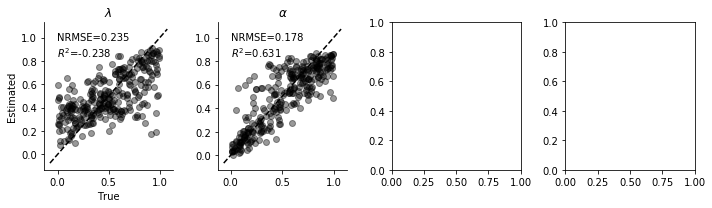

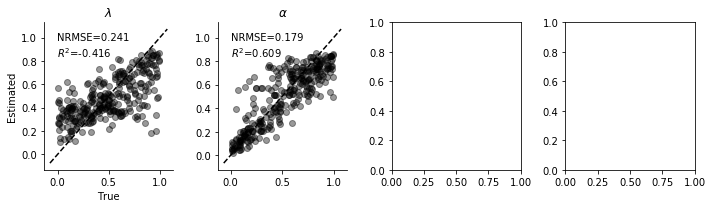

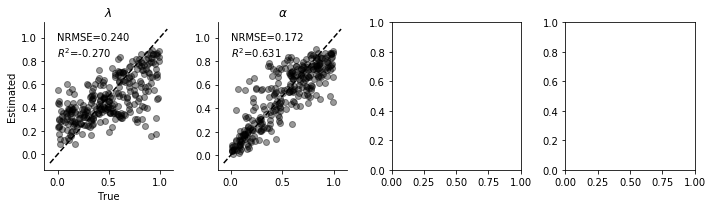

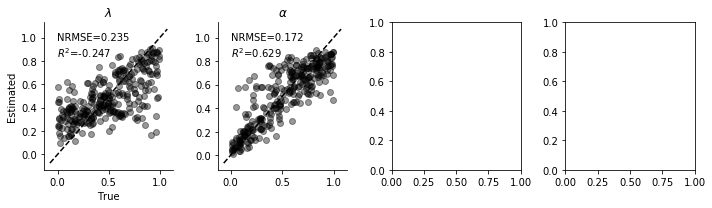

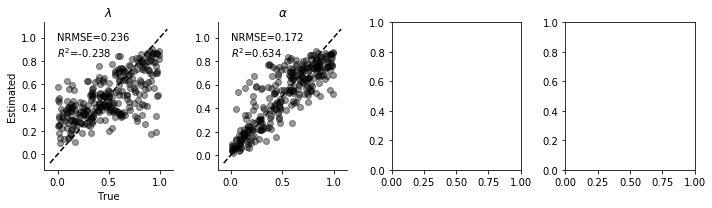

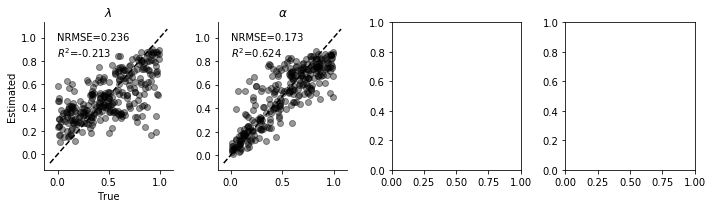

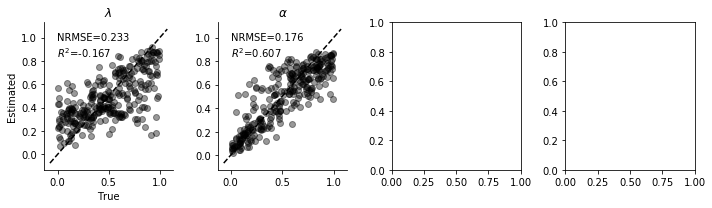

In [ ]:
for ep in range(1, epochs+1):
    
    with tqdm(total = (n_iterations), desc='Epoch {0}, Lr. {1:.4f}'.format(ep, learning_rate())) as p_bar:
        
        # Run epoch online
        run_epoch_online(model, optimizer, data_gen, batch_size, n_iterations, X_test, theta_test, p_bar, 
                          transform=transform, global_step=global_step, clip_value=clip_value)
        
        # Predict test
        theta_pred_test = model(X_test)[0]
        plot_true_est_scatter(model, theta_pred_test, theta_test, 
                              param_names[0:2], figsize=(10, 3), filename=None)
        
        # Save after each chunk
        manager.save()

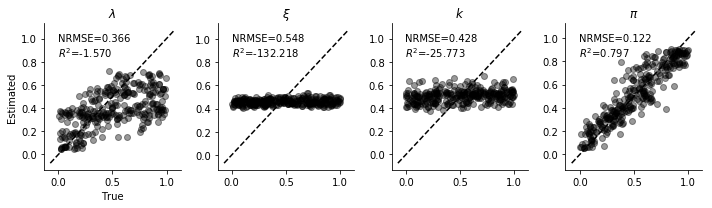

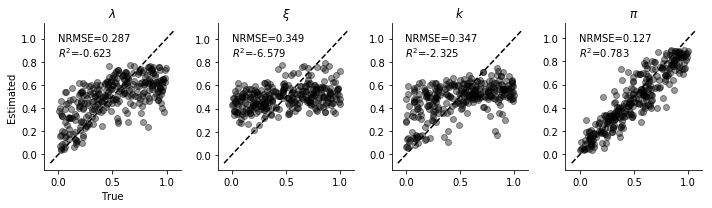

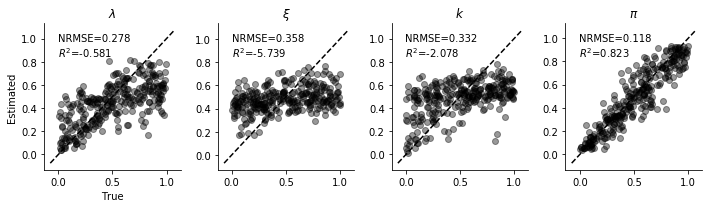

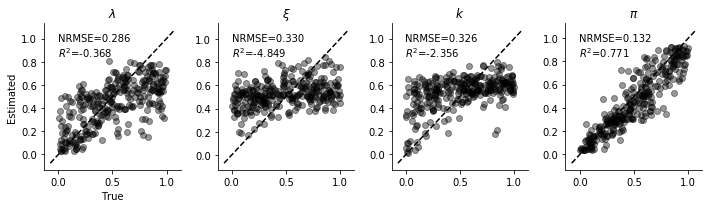

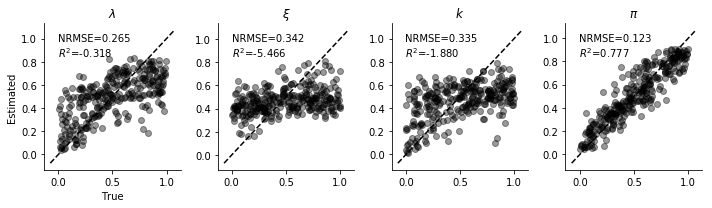

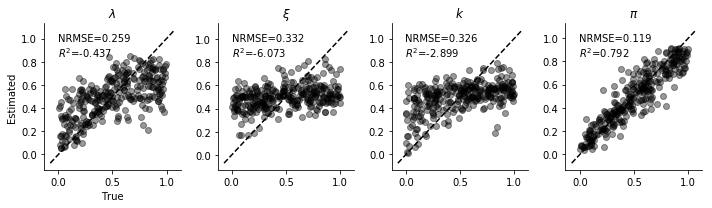

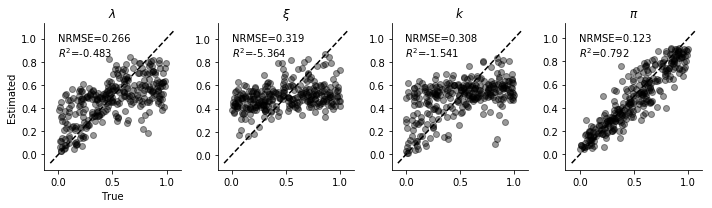

KeyboardInterrupt: 

In [155]:
# for ep in range(1, epochs+1):
    
#     with tqdm(total = (X_train4.shape[0] // batch_size), desc='Epoch {0}, Lr. {1:.4f}'.format(ep, learning_rate())) as p_bar:
        
#         # Run epoch offline (with dev set)
#         run_epoch_offline(model, optimizer, dataset, X_test, theta_test, p_bar, 
#                           transform=transform, global_step=global_step, clip_value=clip_value)
        
#         # Predict test
#         theta_pred_test = model(X_test)[0]
#         plot_true_est_scatter(model, theta_pred_test, theta_test, 
#                               param_names, figsize=(10, 3), filename=None)
        
#         # Save after each chunk
#         manager.save()

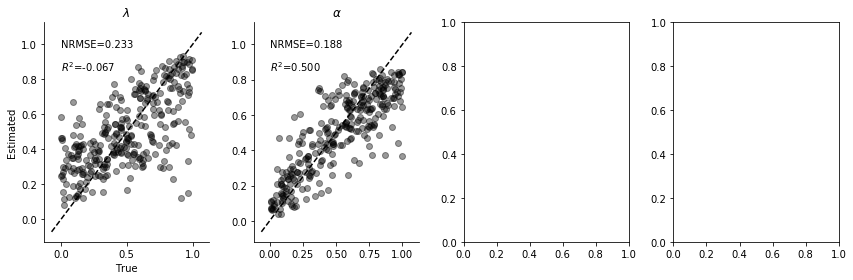

In [105]:
# Predict test
theta_pred_test = model(X_test)[0]
plot_true_est_scatter(model, theta_pred_test, theta_test, 
                      param_names[0:2], figsize=(12, 4), filename=None)